## Figure 2

- Panel A: UMAP of three feature spaces: CP, DP, and CP+DP. Only color a subset of phenotypes.
- Panel B: Pairwise correlations of phenotypes

## Supplementary figure

- Pairwise correlations of all phenotypes

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

In [2]:
figure_dir <- "figures"

output_main_figure_2 <- file.path(figure_dir, "main_figure_2_umap_and_correlation.png")
output_sup_fig_corr <- file.path(figure_dir, "supplementary", "supplementary_pairwise_correlations.png")

focus_corr_colors = c(
    "TRUE" = "blue",
    "FALSE" = "orange"
)
focus_corr_labels  = c(
    "TRUE" = "Yes",
    "FALSE" = "No"
)

In [3]:
# Load UMAP coordinates and process
umap_dir <- file.path("../../mitocheck_data/4.analyze_data/results/")
umap_file <- file.path(umap_dir, "compiled_2D_umap_embeddings.csv")

umap_df <- readr::read_csv(
    umap_file,
    col_types = readr::cols(
        .default = "c",
        Embedding_Value = "d"
    )
) %>%
    dplyr::select(!...1) %>%
    # Wrangle UMAP columns for scatter plot
    tidyr::pivot_wider(names_from = UMAP_Embedding, values_from = Embedding_Value) %>%
    # Generate a new column that we will use for plotting
    # Note, we define focus_phenotypes in themes.r
    dplyr::mutate(Mitocheck_Plot_Label = if_else(
        Mitocheck_Phenotypic_Class %in% focus_phenotypes,
        Mitocheck_Phenotypic_Class,
        "Other"
    ))

umap_df$Mitocheck_Plot_Label <-
    dplyr::recode_factor(umap_df$Mitocheck_Plot_Label, !!!focus_phenotype_labels)

umap_df$Feature_Type <-
    dplyr::recode_factor(umap_df$Feature_Type, !!!facet_labels)

head(umap_df)

New names:
• `` -> `...1`


Mitocheck_Phenotypic_Class,Feature_Type,Cell_UUID,UMAP1,UMAP2,Mitocheck_Plot_Label
<chr>,<fct>,<chr>,<dbl>,<dbl>,<fct>
Large,CellProfiler,21da27ab-873a-41f4-ab98-49170cae9a2d,6.878828,5.770409,Large
Large,CellProfiler,82f7949b-4ea2-45c8-8dd9-7854caf49077,9.861546,3.066624,Large
Large,CellProfiler,cec7234f-fe35-4411-aded-f8112bb31219,6.802670,5.958431,Large
Large,CellProfiler,43d9e7c9-c9ec-45ce-8820-048bfb896989,8.546513,6.359310,Large
Large,CellProfiler,63ce6652-338e-4afd-9c77-dbc0e903bf92,8.440182,6.067466,Large
Large,CellProfiler,08c1dd64-a50a-470a-8fac-3df28fd3b825,10.021554,2.915943,Large


In [4]:
# Create a background dataset to show in greyed color across all facets
umap_focus_df <- umap_df %>% 
    dplyr::filter(Mitocheck_Phenotypic_Class %in% focus_phenotypes)

# Custom function for name repair
name_repair_function <- function(names) {
  names[1] <- paste0(names[1], "_original")
  return(names)
}

df_background <- tidyr::crossing(
    umap_df,
    Mitocheck_Phenotypic_Class = unique(umap_focus_df$Mitocheck_Phenotypic_Class),
    .name_repair = name_repair_function
)

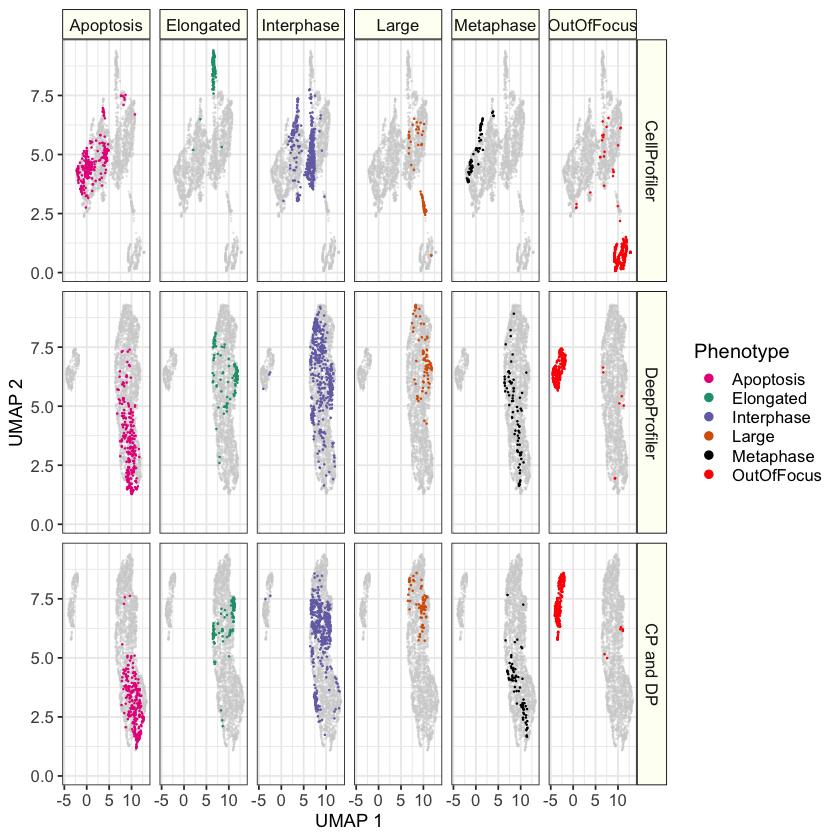

In [5]:
umap_fig_gg <- (
    ggplot(
        umap_df %>% dplyr::filter(Mitocheck_Plot_Label %in% focus_phenotypes),
        aes(x = UMAP1, y = UMAP2)
    )
    + geom_point(
        data = df_background,
        color = "lightgray",
        size = 0.05,
        alpha = 0.4
    )
    + geom_point(
        aes(color = Mitocheck_Phenotypic_Class),
        size = 0.05
    )
    + facet_grid("Feature_Type~Mitocheck_Phenotypic_Class")
    + theme_bw()
    + scale_color_manual(
        "Phenotype",
        values = focus_phenotype_colors,
        labels = focus_phenotype_labels
    )
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
)

umap_fig_gg

## Distributions of all pairwise correlations

In [6]:
# Load data
corr_dir <- file.path("..", "1.split_data", "data")

corr_df <- list()
for (feature_space in c("CP", "DP", "CP_and_DP")) {
    file_name <- file.path(
        corr_dir,
        paste0("pairwise_correlations_", feature_space, ".tsv.gz")
    )
    corr_df[[feature_space]] <- (
        readr::read_tsv(file_name, show_col_types = FALSE) %>%
        dplyr::mutate(feature_space = feature_space)
    )
}

corr_df <- do.call(rbind, corr_df) %>%
    dplyr::mutate(same_label = Row_Label == Pairwise_Row_Label)

corr_df$feature_space <-
    dplyr::recode_factor(corr_df$feature_space, !!!facet_labels)

print(dim(corr_df))
head(corr_df)

[1] 12282273        7


Row_ID,Pairwise_Row_ID,Correlation,Row_Label,Pairwise_Row_Label,feature_space,same_label
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<lgl>
0,1,-0.01702081,Polylobed,Interphase,CellProfiler,FALSE
0,2,0.21152708,Polylobed,Large,CellProfiler,FALSE
0,3,0.15083955,Polylobed,OutOfFocus,CellProfiler,FALSE
0,4,0.11013075,Polylobed,Interphase,CellProfiler,FALSE
0,5,-0.04285112,Polylobed,Anaphase,CellProfiler,FALSE
0,6,0.32697039,Polylobed,Binuclear,CellProfiler,FALSE


## Distributions of focused pairwise correlations

In [7]:
focused_corr_df <- corr_df %>%
    dplyr::filter(
        Row_Label %in% focus_phenotypes |
        Pairwise_Row_Label %in% focus_phenotypes
    )

print(dim(focused_corr_df))
head(focused_corr_df)

[1] 8435070       7


Row_ID,Pairwise_Row_ID,Correlation,Row_Label,Pairwise_Row_Label,feature_space,same_label
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<lgl>
0,1,-0.01702081,Polylobed,Interphase,CellProfiler,FALSE
0,2,0.21152708,Polylobed,Large,CellProfiler,FALSE
0,3,0.15083955,Polylobed,OutOfFocus,CellProfiler,FALSE
0,4,0.11013075,Polylobed,Interphase,CellProfiler,FALSE
0,8,-0.21870789,Polylobed,Apoptosis,CellProfiler,FALSE
0,9,0.02528050,Polylobed,OutOfFocus,CellProfiler,FALSE


In [8]:
all_focus_phenotype_corr_df <- list()

for (phenotype in focus_phenotypes) {
    phenotype_specific_corr_df <- focused_corr_df %>%
        dplyr::filter(
            Row_Label == !!phenotype |
            Pairwise_Row_Label == !!phenotype
        )
    
    same_phenotype_specific_corr_df <- phenotype_specific_corr_df %>%
        dplyr::filter(same_label) %>%
        dplyr::mutate(first_compare = phenotype, second_compare = phenotype)
    
    diff_phenotype_specific_corr_df <- phenotype_specific_corr_df %>%
        dplyr::filter(!same_label) %>%
        dplyr::mutate(first_compare = !!phenotype) %>%
        dplyr::mutate(
            second_compare = if_else(
                Row_Label == !!phenotype,
                Pairwise_Row_Label,
                Row_Label
            )
        )

    all_focus_phenotype_corr_df[[phenotype]] <- dplyr::bind_rows(
        same_phenotype_specific_corr_df,
        diff_phenotype_specific_corr_df
    )
}

all_focus_phenotype_corr_df <- do.call(rbind, all_focus_phenotype_corr_df) 

all_focus_phenotype_corr_df$first_compare <-
    dplyr::recode_factor(all_focus_phenotype_corr_df$first_compare, !!!focus_phenotype_labels)

dim(all_focus_phenotype_corr_df)
head(all_focus_phenotype_corr_df, 3)

[1] 10265727        9

Row_ID,Pairwise_Row_ID,Correlation,Row_Label,Pairwise_Row_Label,feature_space,same_label,first_compare,second_compare
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<lgl>,<fct>,<chr>
8,11,0.5843282,Apoptosis,Apoptosis,CellProfiler,TRUE,Apoptosis,Apoptosis
8,19,0.8934814,Apoptosis,Apoptosis,CellProfiler,TRUE,Apoptosis,Apoptosis
8,37,0.6977293,Apoptosis,Apoptosis,CellProfiler,TRUE,Apoptosis,Apoptosis


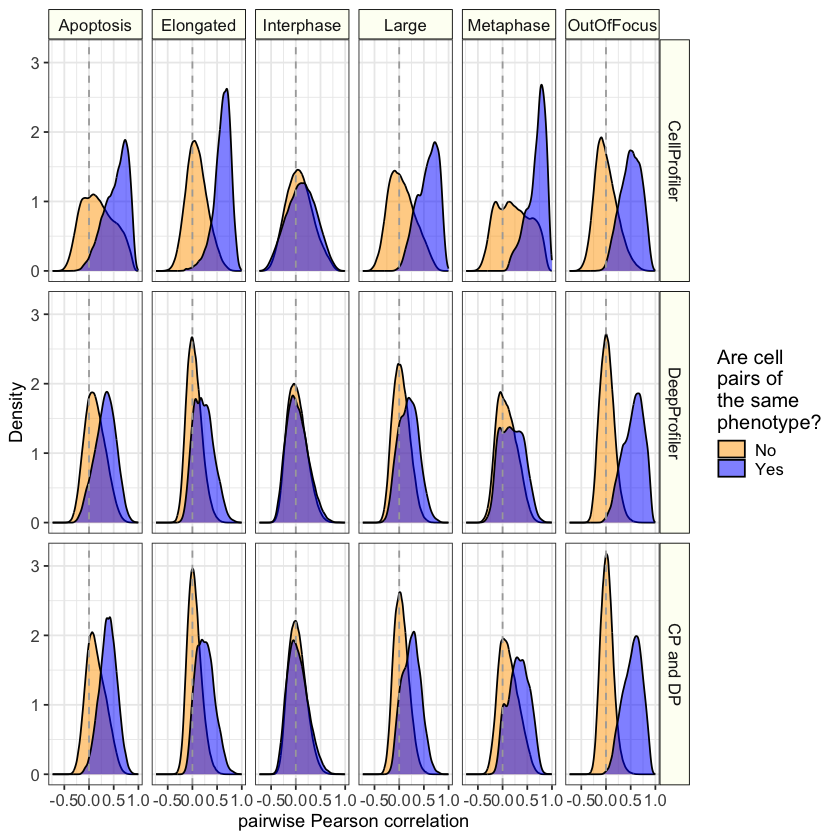

In [9]:
focus_phenotype_gg <- (
    ggplot(all_focus_phenotype_corr_df, aes(x = Correlation))
    + geom_density(aes(fill = same_label), alpha = 0.5)
    + facet_grid("feature_space~first_compare")
    + theme_bw()
    + scale_fill_manual(
        "Are cell\npairs of\nthe same\nphenotype?",
        values = focus_corr_colors,
        labels = focus_corr_labels
    )
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "pairwise Pearson correlation", y = "Density")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey")
)

focus_phenotype_gg

## Compile full figure 2

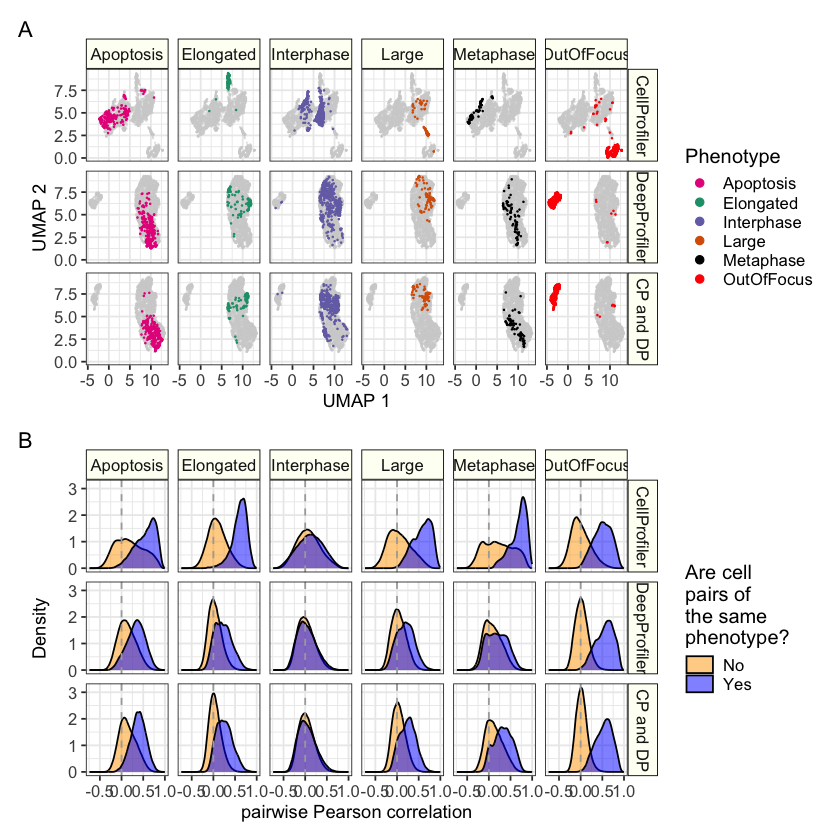

In [10]:
fig_2_gg <- (
    umap_fig_gg /
    focus_phenotype_gg
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(1, 1))

ggsave(output_main_figure_2, dpi = 500, height = 7.5, width = 8)

fig_2_gg

## Supplementary figure

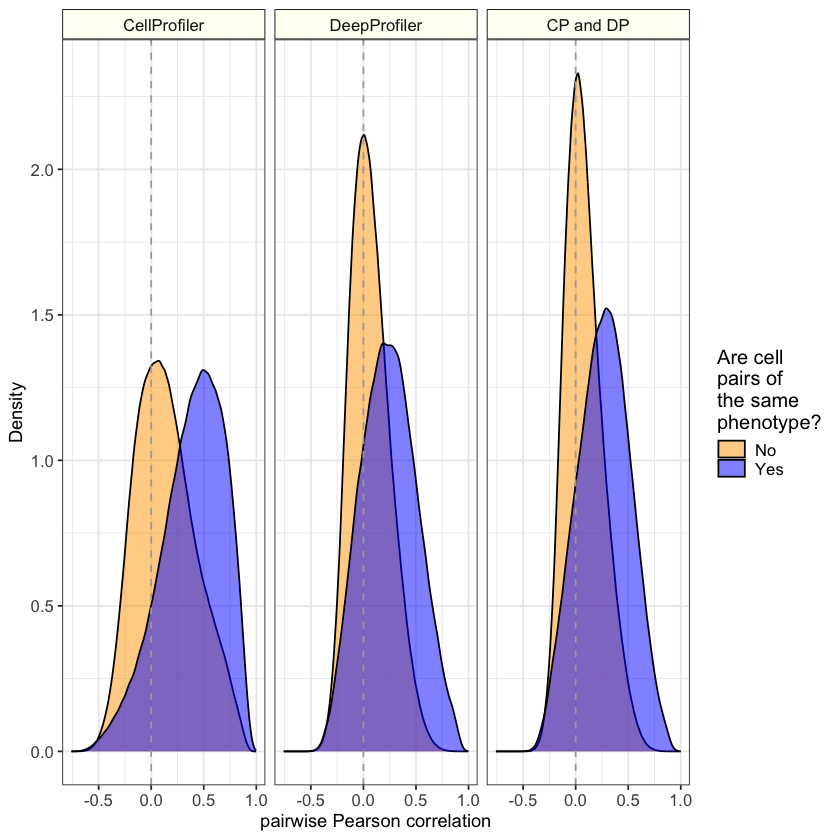

In [11]:
total_pairwise_corr_gg <- (
    ggplot(corr_df, aes(x = Correlation))
    + geom_density(aes(fill = same_label), alpha = 0.5)
    + facet_wrap("~feature_space")
    + theme_bw()
    + scale_fill_manual(
        "Are cell\npairs of\nthe same\nphenotype?",
        values = focus_corr_colors,
        labels = focus_corr_labels
    )
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "pairwise Pearson correlation", y = "Density")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey")
)

total_pairwise_corr_gg

### Now generate all other phenotype correlation plots

In [12]:
other_phenotypes <- setdiff(unique(corr_df$Row_Label), focus_phenotypes)
other_phenotypes

[1] "Polylobed"          "Anaphase"           "Binuclear"         
[4] "MetaphaseAlignment" "SmallIrregular"     "Prometaphase"      
[7] "Hole"               "ADCCM"              "Grape"

In [13]:
other_corr_df <- corr_df %>%
    dplyr::filter(
        Row_Label %in% other_phenotypes |
        Pairwise_Row_Label %in% other_phenotypes
    )

print(dim(other_corr_df))
head(other_corr_df)

[1] 9902763       7


Row_ID,Pairwise_Row_ID,Correlation,Row_Label,Pairwise_Row_Label,feature_space,same_label
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<lgl>
0,1,-0.01702081,Polylobed,Interphase,CellProfiler,FALSE
0,2,0.21152708,Polylobed,Large,CellProfiler,FALSE
0,3,0.15083955,Polylobed,OutOfFocus,CellProfiler,FALSE
0,4,0.11013075,Polylobed,Interphase,CellProfiler,FALSE
0,5,-0.04285112,Polylobed,Anaphase,CellProfiler,FALSE
0,6,0.32697039,Polylobed,Binuclear,CellProfiler,FALSE


In [14]:
other_phenotype_corr_df <- list()

for (phenotype in other_phenotypes) {
    phenotype_specific_corr_df <- other_corr_df %>%
        dplyr::filter(
            Row_Label == !!phenotype |
            Pairwise_Row_Label == !!phenotype
        )
    
    same_phenotype_specific_corr_df <- phenotype_specific_corr_df %>%
        dplyr::filter(same_label) %>%
        dplyr::mutate(first_compare = phenotype, second_compare = phenotype)
    
    diff_phenotype_specific_corr_df <- phenotype_specific_corr_df %>%
        dplyr::filter(!same_label) %>%
        dplyr::mutate(first_compare = !!phenotype) %>%
        dplyr::mutate(
            second_compare = if_else(
                Row_Label == !!phenotype,
                Pairwise_Row_Label,
                Row_Label
            )
        )

    other_phenotype_corr_df[[phenotype]] <- dplyr::bind_rows(
        same_phenotype_specific_corr_df,
        diff_phenotype_specific_corr_df
    )
}

other_phenotype_corr_df <- do.call(rbind, other_phenotype_corr_df) 

dim(other_phenotype_corr_df)
head(other_phenotype_corr_df, 3)

[1] 13182903        9

Row_ID,Pairwise_Row_ID,Correlation,Row_Label,Pairwise_Row_Label,feature_space,same_label,first_compare,second_compare
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<lgl>,<chr>,<chr>
0,7,0.4156310,Polylobed,Polylobed,CellProfiler,TRUE,Polylobed,Polylobed
0,27,0.3463767,Polylobed,Polylobed,CellProfiler,TRUE,Polylobed,Polylobed
0,41,0.3561256,Polylobed,Polylobed,CellProfiler,TRUE,Polylobed,Polylobed


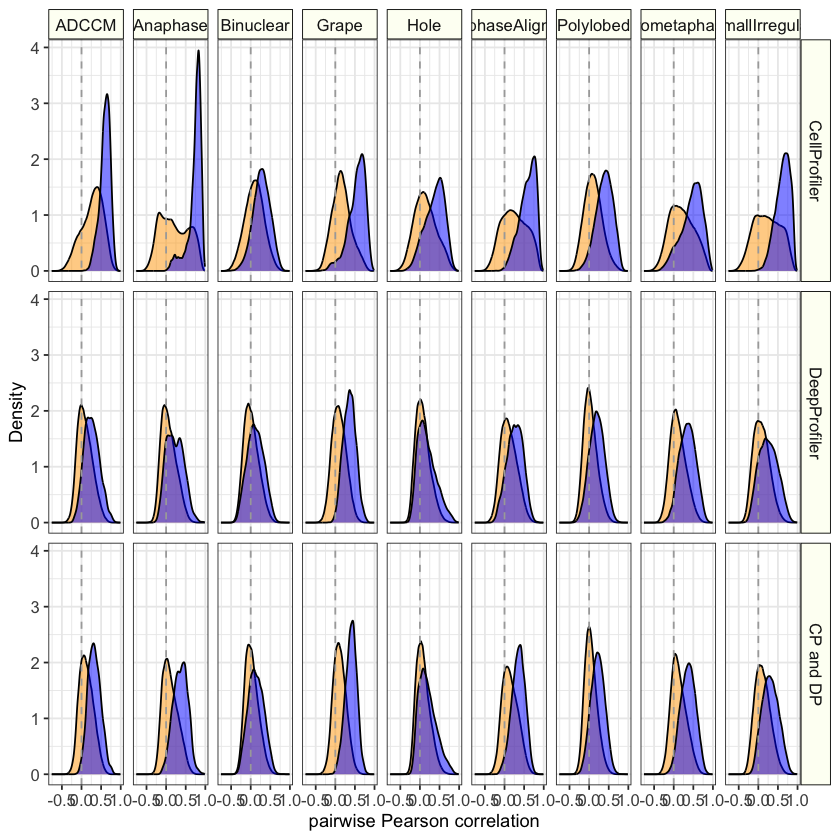

In [15]:
other_phenotype_gg <- (
    ggplot(other_phenotype_corr_df, aes(x = Correlation))
    + geom_density(aes(fill = same_label), alpha = 0.5)
    + facet_grid("feature_space~first_compare")
    + theme_bw()
    + scale_fill_manual(
        "Are cell\npairs of\nthe same\nphenotype?",
        values = focus_corr_colors,
        labels = focus_corr_labels
    )
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "pairwise Pearson correlation", y = "Density")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey")
    + theme(legend.position = "none")
)

other_phenotype_gg

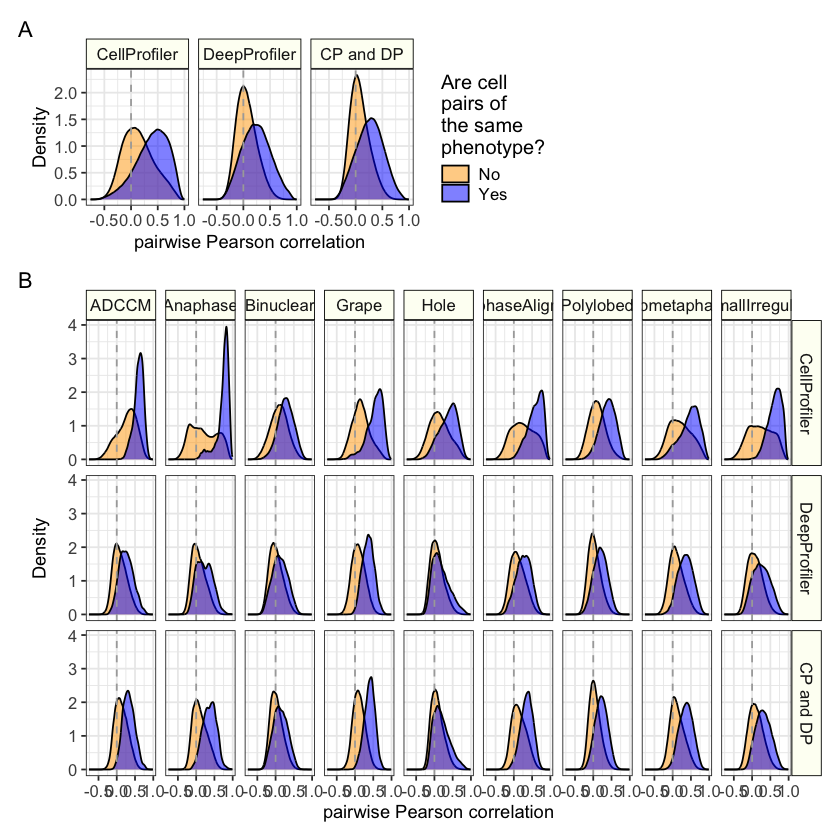

In [16]:
nested_plot <- (
    total_pairwise_corr_gg | plot_spacer()
) + plot_layout(widths = c(3, 2))

sup_fig_gg <- (
    nested_plot /
    other_phenotype_gg
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(0.3, 1))

ggsave(output_sup_fig_corr, dpi = 500, height = 7, width = 14)

sup_fig_gg